In [83]:
import numpy as np
import argparse
import json
from pysam import VariantFile, TabixFile
import gzip
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import scipy.sparse as sparse

In [69]:
chrom = '22'
batch_num = 1
data_dir = '../../DATA/ihart.ms2/genotypes/01'
gnomad_vcf_file = '../data/gnomad.genomes.r3.0.sites.chr22.vcf.bgz'
ped_file = '../../DATA/ihart.ms2/ihart.ped'

In [42]:
with open('%s/info.json' % data_dir, 'r') as f:
	info = json.load(f)
	batch_size = info['batch_size']
	assembly = info['assembly']

with open('../data/chrom_lengths%s.json' % assembly, 'r') as f:
	chrom_length = json.load(f)[chrom]

In [47]:
# pull positions of interest
coord_file = '%s/chr.%s.%d.gen.coordinates.npy' % (data_dir, chrom, batch_num)
pos_data = np.load(coord_file)
if pos_data.shape[0]>0:
    positions = pos_data[:, 1]
    is_snp = pos_data[:, 2].astype(bool)
    is_pass = pos_data[:, 3].astype(bool)
    assert np.all(pos_data[is_snp][1:, 1]>pos_data[is_snp][:-1, 1])
else:
    positions = np.zeros((0,), dtype=int)
print(positions.shape)

(376146,)


In [48]:
refs, alts = [], []
with gzip.open('%s/chr.%s.%d.gen.variants.txt.gz' % (data_dir, chrom, batch_num), 'rt') as f:
    for line in f:
        pieces = line.strip().split('\t', maxsplit=5)
        refs.append(pieces[3])
        alts.append(pieces[4])
print(len(refs), len(alts))

376146 376146


In [124]:
def pull_af_from_info(info):
	af = -1
	for entry in info:
		if entry.startswith('AF='):
			af = float(entry[3:])
			break
	return af

def pull_af_from_gnomad(records, positions, refs, alts):
    position_ref_alt_to_index = dict([((x, r, a), i) for i, (x, r, a) in enumerate(zip(positions, refs, alts))])
    afs = np.zeros((len(positions),))
    for line in records:
        pieces = line.strip().split('\t')
        info = pieces[7].strip().split(';')
        key = (int(pieces[1]), pieces[3], pieces[4])
        if key in position_ref_alt_to_index:
            afs[position_ref_alt_to_index[key]] = pull_af_from_info(info)
    return np.clip(np.array(afs), 3/71702, 1-(3/71702))


In [125]:
# load AF from appropriate section of gnomad vcf_file
if positions.shape[0]>0:
    vcf = TabixFile(gnomad_vcf_file, parser=None)
    if batch_size is not None:
        start_pos, end_pos = batch_num*batch_size, (batch_num+1)*batch_size
        print('Interval', start_pos, end_pos)
        gnomad_afs = pull_af_from_gnomad(vcf.fetch(reference='chr%s' % chrom, start=start_pos, end=end_pos),
                                        positions, refs, alts)
    else:
        gnomad_afs = pull_af_from_gnomad(vcf.fetch(reference='chr%s' % chrom),
                                                          positions, refs, alts)


Interval 10000000 20000000


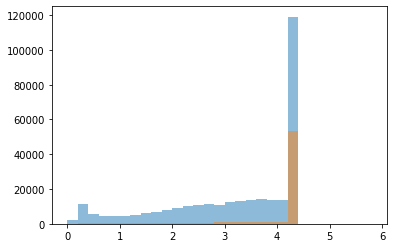

In [126]:
plt.hist(-np.log10(gnomad_afs[is_snp]), alpha=0.5, bins=np.arange(0, 6, 0.2))
plt.hist(-np.log10(gnomad_afs[~is_snp]), alpha=0.5, bins=np.arange(0, 6, 0.2))
plt.show()

In [89]:
class Family():
	def __init__(self, famkey):
		self.id = famkey
		self.parents_to_children = defaultdict(list)
		self.mat_ancestors = []
		self.pat_ancestors = []
		self.descendents = []
		self.ordered_couples = []
		self.individuals = []

	def add_child(self, child_id, mother_id, father_id):
		if child_id in self.mat_ancestors:
			self.mat_ancestors.remove(child_id)
		if child_id in self.pat_ancestors:
			self.pat_ancestors.remove(child_id)

		if mother_id not in self.individuals:
			self.mat_ancestors.append(mother_id)
		if father_id not in self.individuals:
			self.pat_ancestors.append(father_id)
		self.parents_to_children[(mother_id, father_id)].append(child_id)
		random.shuffle(self.parents_to_children[(mother_id, father_id)])

		self._reset_individuals()

	def get_parents(self, child_id):
		for ((mom, dad), children) in self.parents_to_children:
			if child_id in children:
				return (mom, dad)
		return None

	def _reset_individuals(self):
		self.descendents = []
		self.ordered_couples = []
		parents = set(self.parents_to_children.keys())
		while len(parents) > 0:
			already_added = set()
			for mom, dad in parents:
				if (mom in self.mat_ancestors or mom in self.descendents) and (dad in self.pat_ancestors or dad in self.descendents):
					self.ordered_couples.append((mom, dad))
					self.descendents.extend(self.parents_to_children[(mom, dad)])
					already_added.add((mom, dad))
			parents = parents - already_added
			if len(already_added) == 0:
				raise Exception('Circular pedigree.')
		self.individuals = self.mat_ancestors + self.pat_ancestors + self.descendents

	def __lt__(self, other):
		return self.id < other.id

	def __eq__(self, other):
		return self.id == other.id

	def __hash__(self):
		return hash(self.id)

	def __len__(self):
		return len(self.individuals)

	def __str__(self):
		return self.id

	def num_ancestors(self):
		return len(self.mat_ancestors) + len(self.pat_ancestors)

	def num_descendents(self):
		return len(self.descendents)


def pull_families(ped_file):
	# pull families from ped file
	families = dict()
	with open(ped_file, 'r') as f:	
		for line in f:
			pieces = line.strip().split('\t')
			if len(pieces) < 4:
				print('ped parsing error', line)
			else:
				fam_id, child_id, f_id, m_id = pieces[0:4]

				if f_id != '0' and m_id != '0':
					if fam_id not in families:
						families[fam_id] = Family(fam_id)
					families[fam_id].add_child(child_id, m_id, f_id)
	families = sorted([x for x in families.values()])
		
	print('families pulled %d' % len(families))
	return families

families = pull_families(ped_file)
ancestors = sorted(sum([x.mat_ancestors + x.pat_ancestors for x in families], []))
print('ancestors', len(ancestors))

families pulled 881
ancestors 1789


In [90]:
# pull samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])
ind_indices = [sample_id_to_index[x] for x in ancestors if x in sample_id_to_index]  

# pull genotypes
data = sparse.load_npz('%s/chr.%s.%d.gen.npz' % (data_dir, chrom, batch_num))[ind_indices, :]
num_het = (data==1).sum(axis=0).A.flatten()
num_homalt = (data==2).sum(axis=0).A.flatten()
num_missing = (data<0).sum(axis=0).A.flatten()
num_homref = len(ind_indices) - num_het - num_homalt - num_missing
assert np.all(num_homref >= 0)

af = np.zeros((data.shape[1],))
all_missing = (num_homref + num_het + num_homalt) == 0
af[~all_missing] = (num_het[~all_missing] + 2*num_homalt[~all_missing])/(2*num_homref[~all_missing] + 2*num_het[~all_missing] + 2*num_homalt[~all_missing])


In [92]:
print(np.sum(all_missing), np.sum(~all_missing))

29 376117


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


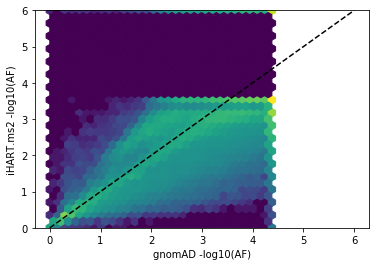

In [117]:
plt.hexbin(-np.log10(gnomad_afs[is_snp]), 
            np.clip(-np.log10(af[is_snp]), 0, 6), bins='log', gridsize=30)#, alpha=0.01, marker='.')
#plt.scatter(np.clip(-np.log10(gnomad_afs[~is_snp]), 0, 5), 
#            np.clip(-np.log10(af[~is_snp]), 0, 5), alpha=0.1, marker='.')
plt.plot([0, 6], [0, 6], color='black', linestyle='--')
plt.xlabel('gnomAD -log10(AF)')
plt.ylabel('iHART.ms2 -log10(AF)')

plt.show()